# CNN - CIFAR10 - Data Augmentation

In [1]:
# First, import TF and get its version.
import tensorflow as tf
from sympy.physics.units import action

tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('\033[91m' + 'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('\033[92m' + 'OK: TensorFlow >= 2.0.0' + '.\033[0m')

ModuleNotFoundError: No module named 'tensorflow.python.distribute.load_context'

In [2]:
print(tf_version)
tf.config.list_physical_devices('GPU')

2.15.1


[]

In [2]:
print(tf.test.is_built_with_cuda())

NameError: name 'tf' is not defined

## Loading the packages

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

Define a function to plot some images from CIFAR and load the dataset.

170498071/170498071 [==============================] - 26s 0us/step


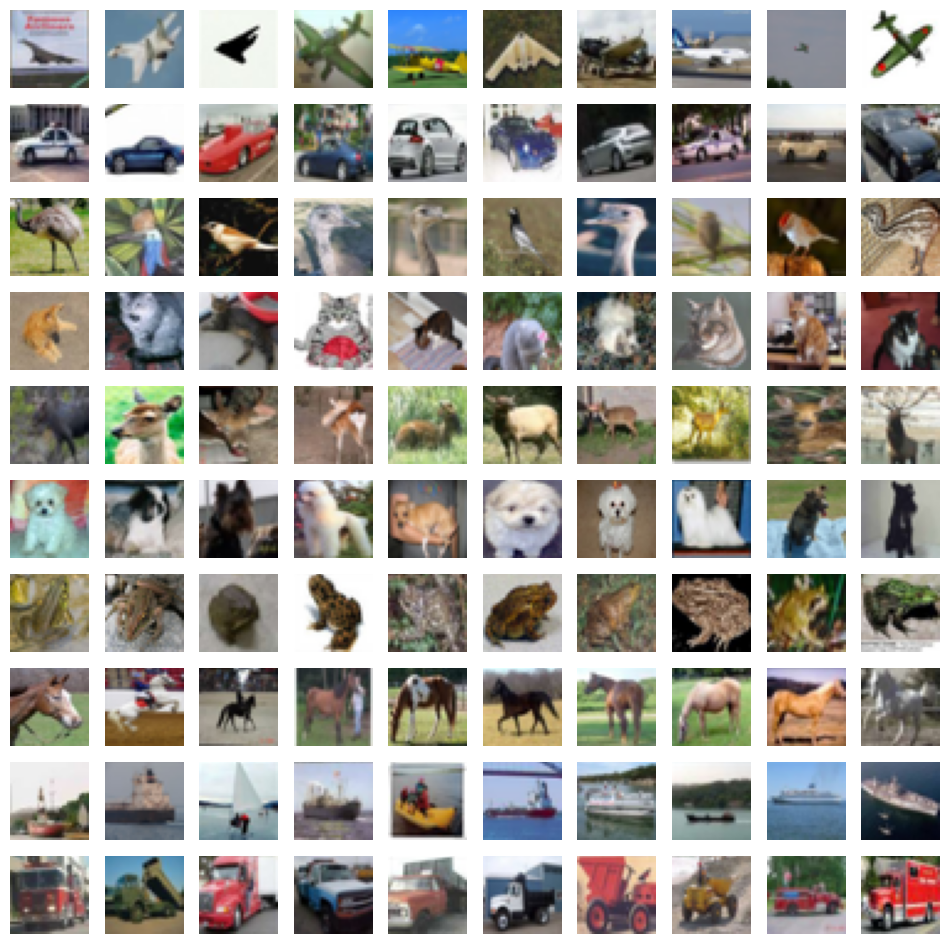

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [4]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

### Preprocessing data
After loading and splitting the data, we need to preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the \[0, 1\] interval.

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [6]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [7]:
X_train.shape

(50000, 32, 32, 3)

## Define the network
The neural network will be a CNN. Follow the structure given in the exercise 1.

In [8]:
def get_cnn():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(10, activation='softmax'))

    return model

cnn = get_cnn()
cnn.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2048)             

## Compile and train the network

When compiling the model, we need to specify the loss function, the optimizer and the metrics we want to track during the training. In Keras, we need to call the methods `compile()` and `fit()`. We will train through E epochs, using batches of size B, as specified in the exercise 1.

- The `categorical_crossentropy` loss is relevant for multiclass, single-label classification problem. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used `binary_crossentropy`.
- The `adam` optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

In [9]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = cnn.fit(X_train, Y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, Y_test))


Epoch 1/10


391/391 [==============================] - 15s 36ms/step - loss: 1.5861 - accuracy: 0.4316 - val_loss: 1.3788 - val_accuracy: 0.5087
Epoch 2/10
391/391 [==============================] - 14s 35ms/step - loss: 1.2349 - accuracy: 0.5643 - val_loss: 1.1804 - val_accuracy: 0.5849
Epoch 3/10
391/391 [==============================] - 13s 34ms/step - loss: 1.0704 - accuracy: 0.6269 - val_loss: 1.0257 - val_accuracy: 0.6386
Epoch 4/10
391/391 [==============================] - 14s 35ms/step - loss: 0.9703 - accuracy: 0.6647 - val_loss: 0.9619 - val_accuracy: 0.6725
Epoch 5/10
391/391 [==============================] - 14s 35ms/step - loss: 0.9001 - accuracy: 0.6875 - val_loss: 0.9186 - val_accuracy: 0.6831
Epoch 6/10
391/391 [==============================] - 13s 34ms/step - loss: 0.8443 - accuracy: 0.7060 - val_loss: 0.8921 - val_accuracy: 0.6900
Epoch 7/10
391/391 [==============================] - 14s 35ms/step - loss: 0.8093 - accuracy: 0.7197 - val_loss: 0.8738 - val_accura

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss and accuracy evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

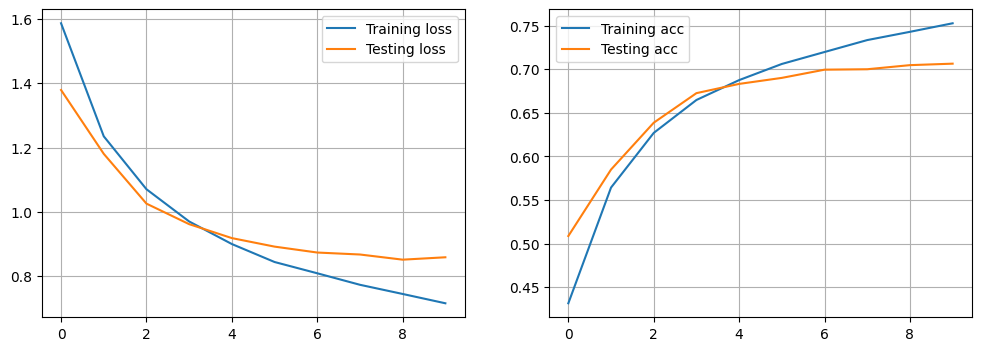

In [10]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [11]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

loss_train, metric_train = cnn.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', loss_train)
print('Train accuracy:', metric_train)

Test loss: 0.8590138554573059
Test accuracy: 0.7063000202178955
Train loss: 0.6830601692199707
Train accuracy: 0.762179970741272


### Confusion matrix
We can call the `predict()` function to get the predicted classes. The output array of ground truth `y_test` and the predicted classes can then be fed to the `confusion_matrix()` function of [sklearn metrics package](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

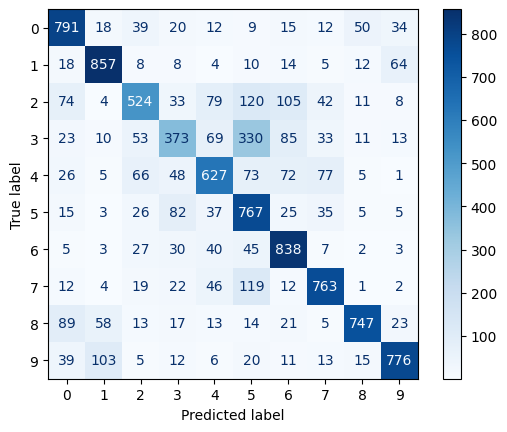

In [12]:
pred = cnn.predict(X_test, verbose=0)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')

## Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by hart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def one_hot_generator(generator, num_classes):
    for batch_X, batch_y in generator:
        yield batch_X, utils.to_categorical(batch_y, num_classes)

Don't forget to reset your network (by defining it again). You need then to compile the network and train it. The call to the `fit()` function has to be replaced by a call to `fit_generator()` and using the data flow defined above.

b# Comment
`.fit_generator()` was not available on the model, `.fit()` worked instead.

Epoch 1/20
390/390 [==============================] - 47s 117ms/step - loss: 1.9152 - accuracy: 0.3004 - val_loss: 1.8037 - val_accuracy: 0.3496
Epoch 2/20
390/390 [==============================] - 46s 118ms/step - loss: 1.7508 - accuracy: 0.3710 - val_loss: 1.7011 - val_accuracy: 0.3825
Epoch 3/20
390/390 [==============================] - 46s 119ms/step - loss: 1.6755 - accuracy: 0.3991 - val_loss: 1.6264 - val_accuracy: 0.4135
Epoch 4/20
390/390 [==============================] - 79s 204ms/step - loss: 1.6245 - accuracy: 0.4168 - val_loss: 1.5745 - val_accuracy: 0.4377
Epoch 5/20
239/390 [=================>............] - ETA: 23s - loss: 1.5859 - accuracy: 0.4336

KeyboardInterrupt: 

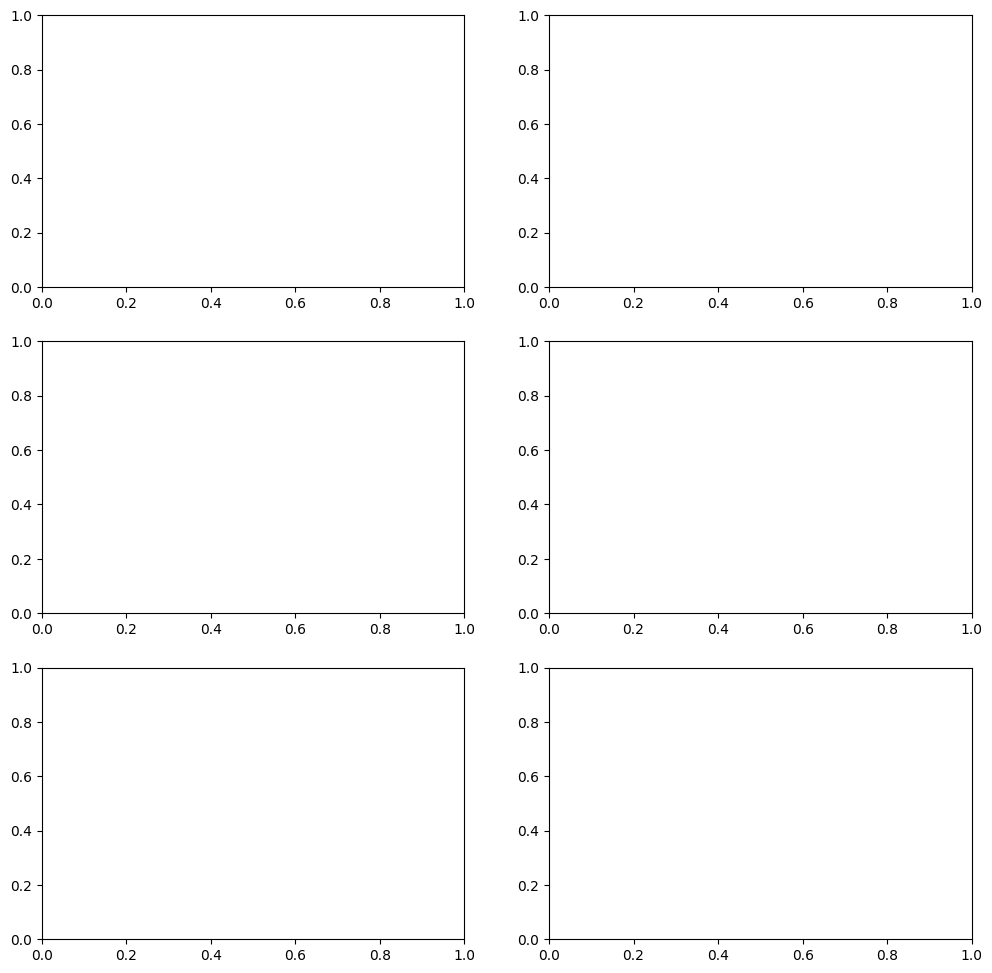

In [25]:
settings = [
    {
        "rotation_range": 90,
        "width_shift_range": 0.2,
        "height_shift_range": 0.2,
        "shear_range": 0.3,
        "zoom_range": 0.3,
    }, {
        "rotation_range": 20,
        "width_shift_range": 0.1,
        "height_shift_range": 0.1,
        "shear_range": 0.2,
        "zoom_range": 0.2,
    }, {
        "rotation_range": 5,
        "width_shift_range": 0.05,
        "height_shift_range": 0.05,
        "shear_range": 0.15,
        "zoom_range": 0.15,
    }
]

fig, axes = plt.subplots(len(settings), 2, figsize=(12, 4 * len(settings)))

losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []

for i, setting in enumerate(settings):
    # Define the data augmentation pipelines, one for train set, one for test set
    gen = ImageDataGenerator(rotation_range=setting["rotation_range"],
                             width_shift_range=setting["width_shift_range"],
                             height_shift_range=setting["height_shift_range"],
                             shear_range=setting["shear_range"],
                             zoom_range=setting["zoom_range"])

    augmented_train_data = one_hot_generator(gen.flow(X_train, y_train, batch_size=128), n_classes)
    augmented_test_data = one_hot_generator(gen.flow(X_test, y_test, batch_size=128), n_classes)

    # Compile and train the network
    cnn = get_cnn()
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    log = cnn.fit(augmented_train_data,
                  steps_per_epoch=len(X_train) // 128,
                  epochs=20,
                  validation_data=augmented_test_data,
                  validation_steps=len(X_test) // 128)

    loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
    loss_train, metric_train = cnn.evaluate(X_train, Y_train, verbose=0)
    losses_train.append(loss_train)
    accuracies_train.append(metric_train)
    losses_test.append(loss_test)
    accuracies_test.append(metric_test)

    axes[i, 0].plot(log.history['loss'], label='Training loss')
    axes[i, 0].plot(log.history['val_loss'], label='Testing loss')
    axes[i, 0].set_title(f'Loss DA v{i+1}')
    axes[i, 0].legend()
    axes[i, 0].grid()
    axes[i, 1].plot(log.history['accuracy'], label='Training acc')
    axes[i, 1].plot(log.history['val_accuracy'], label='Testing acc')
    axes[i, 1].set_title(f'Accuracy DA v{i+1}')
    axes[i, 1].legend()
    axes[i, 1].grid()

plt.show()

In [13]:
for i, (test_loss, test_acc, train_loss, train_acc) in enumerate(zip(losses_test, accuracies_test, losses_train, accuracies_train)):
    print(f"DA V{i+1}")
    print("Test loss:", test_loss)
    print("Test accuracy:", test_acc)
    print("Train loss:", train_loss)
    print("Train accuracy:", train_acc)
    print("-"*20)

DA V1
Test loss: 1.4431097507476807
Test accuracy: 0.5099999904632568
Train loss: 1.4470374584197998
Train accuracy: 0.5102599859237671
--------------------
DA V2
Test loss: 0.9887955188751221
Test accuracy: 0.6610000133514404
Train loss: 0.9486761689186096
Train accuracy: 0.6782600283622742
--------------------
DA V3
Test loss: 0.8922755122184753
Test accuracy: 0.695900022983551
Train loss: 0.7949897050857544
Train accuracy: 0.7247800230979919
--------------------


### Table of results

Describe your data augmentation strategies here.

| CNN        | Architecture description | Acc. train | Acc. test |
|------------|--------------------------|------------|-----------|
| No DA      | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.777      | 0.716     |
| With DA v1 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.510      | 0.501     |
| With DA v2 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.678      | 0.661     |
| With DA v3 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.725      | 0.696     |

## Visualizing What My Model Learns

It’s often said that deep-learning models are “black boxes”: learning representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep-learning models, it’s definitely not true for convnets. The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts.
Here we attempt to visualize the intermediate CNN outputs (intermediate activations). Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network.
We want to visualize feature maps with three dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

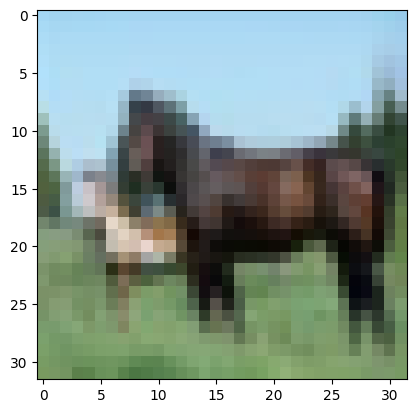

In [13]:
# visualize image number 12
test_im1 = X_train[12]
plt.imshow(test_im1)
plt.show()

In [15]:
#  Now implement a code to visualise all the filters at a given layer. 
#  Hints : use subplots to have a grid of images, use for loops to avoid code repetition.

#  Use the code shown in-class to perform this exercise
from tensorflow.keras import models

1/1 [==============================] - 0s 57ms/step


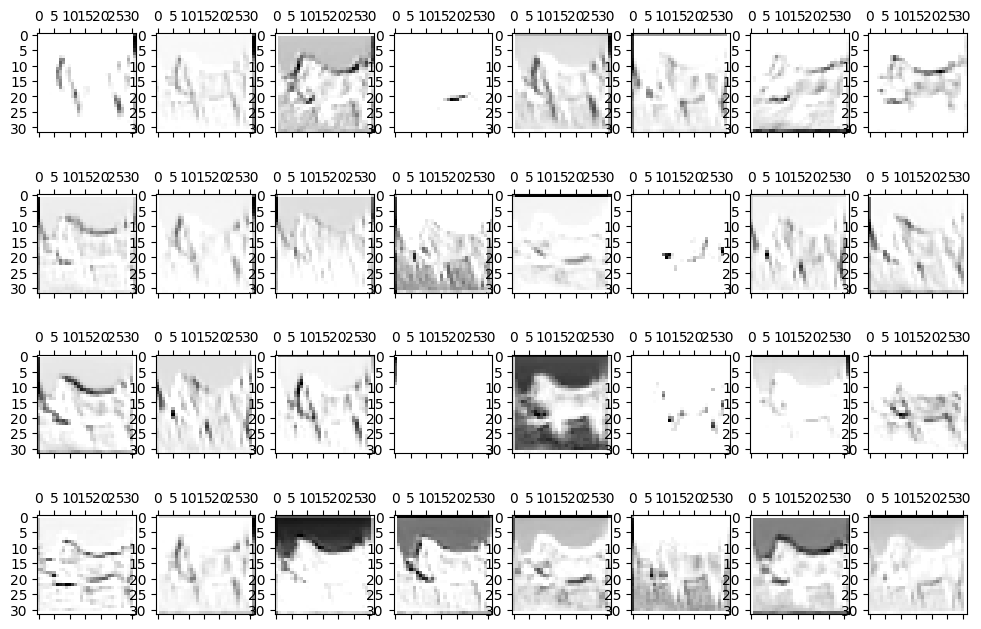

In [21]:
n_filters = 32
n_columns = 8
n_rows = n_filters // n_columns

fig, axes = plt.subplots(n_rows, n_columns, figsize=(12, 2 * n_rows))
layer_1st_conv = cnn.layers[0].output

activation_model = models.Model(inputs=cnn.input, outputs=layer_1st_conv)

test_im1 = test_im1.reshape(1,32,32,3)

first_layer_activation = activation_model.predict(test_im1)

for i in range(n_rows):
    for j in range(n_columns):
        index = i * n_columns + j
        axes[i, j].matshow(first_layer_activation[0, :, :, index], cmap='Greys')

## Optional : Deeper Models
Let's play here with a deeper CNN model on CIFAR10 using a structure inspired by VGGNet: [[Conv2D $\rightarrow$ relu $\rightarrow$ BN]*3 $\rightarrow$ MaxPool2D $\rightarrow$ Dropout]*4 $\rightarrow$ Flatten $\rightarrow$ Dense $\rightarrow$ Dropout $\rightarrow$ Out.
In this structure, BN means Batch Normalisation. You can try different options but a configuration with blocks of 64 filters of size 3 with same padding and stride 1, max pooling of size 2 and stride 2, dropouts of 0.2 and a dense layer of 256 neurons should bring your performance around 80-85\% on CIFAR10.

You probably  need to use a GPU to train such networks and play with different settings. You may use freely available GPUs on Colab, see https://colab.research.google.com/
To activate the gpu on Colab, go to Edit > Notebook settings and select GPU.}. Report your best performances with and without data augmentation as in Exercise 1. What are your observations.

In [3]:
#  Your code here

## Analysis of a Deep Architecture

The analysis of the deep CNN architectures we did in the class covered the evolution observed on the ImageNet LSVRC competition until 2017. New architectures were introduced after that, such as for exemple the **Inception-v4**, **XCeption**, **EfficientNet**, etc. Other strategies based on deep CNNs have also emerged for other tasks such as *image detection* (finding bounding boxes around the objects of interest), such as **Yolo** (v1 to v6).

- Pick one of these new architectures that you find interesting (Inception-v4, XCeption, EfficientNet, Yolo, or another one).
- List and provide the reference(s) explaining the architecture (at least the reference to the original paper(s) presenting the architecture).
- Read the article(s) up to the point you have a general understanding of their strategy - no need to understand all the details!
- Re-explain in few phrases what you understood from the architecture doing comparison with the architectures presented in the class.

# YOLOv12

https://arxiv.org/abs/2502.12524



YOLOv12 is the first YOLO model to incorporate the Vision Transformer (ViT). Previously, ViTs were avoided due to their significantly higher computational cost and slower performance compared to traditional CNNs. This is because attention mechanisms scale quadratically with the number of parameters and calculations, whereas CNNs scale linearly. YOLOv12 addresses this by introducing image splits, reducing complexity to a level that is greater than linear but less than quadratic.

Additionally, the model adopts an MLP ratio of 1.2 instead of the typical 4 used in most ViTs, further decreasing the number of parameters. Another notable aspect is the choice of optimizer, YOLOv12 employs SGD, whereas modern deep-learning models more commonly use Adam or AdamW in practice.

## Optional: Review Questions

See pdf of this Practical Work for the review questions.